SECTIONS
- Stock Price Simulation using Geometric Brownian Motion
- Monte Carlo Simulated Price Paths for Single Stock
- Monte Carlo Portfolio Simulation using Matrix Multiplication

In [11]:
# Import Libraries 

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

ticker = yf.Ticker("SPY")
latest = ticker.history(period = "1d")
latest_close = latest['Close'].iloc[-1]

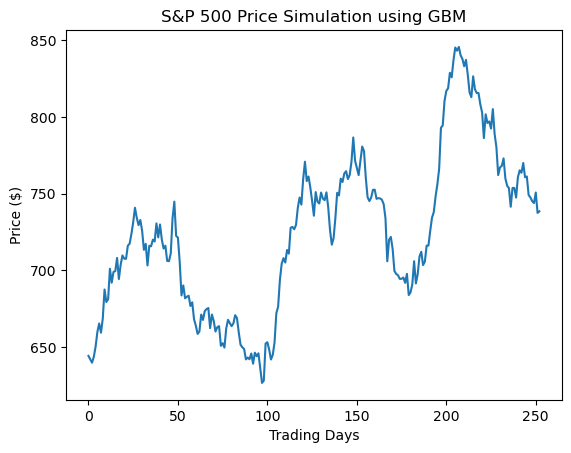

In [12]:
# Stock Price Simulation using Geometric Brownian Motion

'''
GBM assumes that stock prices grow continuously over time, but with some randomness. The formula below takes the average growth (drift) and randomness (volatility) into account.

Equation to simulate GBM:
S_t+1 = S_t * exp((µ - 0.5σ²)∆t + Z_t * σ√∆t), where
- S_t: stock price at time t
- µ: average return (drift)
- σ: volatility
- ∆t: small time step
- Z_t: random value from a standard normal distribution

Assumptions:
- constant drift (µ)
- constant volatility (σ)
- log-normal distribution of prices (Z)
'''

# Basic parameters
S0 = latest_close # initial stock price
T = 1 # time (years)
N = 252 # trading days
dt = T/N # duration of each time step (years)

hist = ticker.history(period = "3y", auto_adjust = True)
logret = np.log(hist['Close'] / hist['Close'].shift(1)).dropna()
lookback = 252 
µ = logret.tail(lookback).mean() * N # expected annual return 
σ = logret.tail(lookback).std(ddof = 1) * np.sqrt(N) # annual volatility

# Simulation
Z = np.random.normal(0, 1, N)
S = np.zeros(N + 1)
S[0] = S0
for t in range(1, N + 1):
    S[t] = S[t-1] * np.exp((µ - 0.5 * σ ** 2) * dt + Z[t-1] * σ * np.sqrt(dt))

# Visualisation
plt.plot(S) 
plt.title("S&P 500 Price Simulation using GBM")
plt.xlabel("Trading Days")
plt.ylabel("Price ($)")
plt.show()

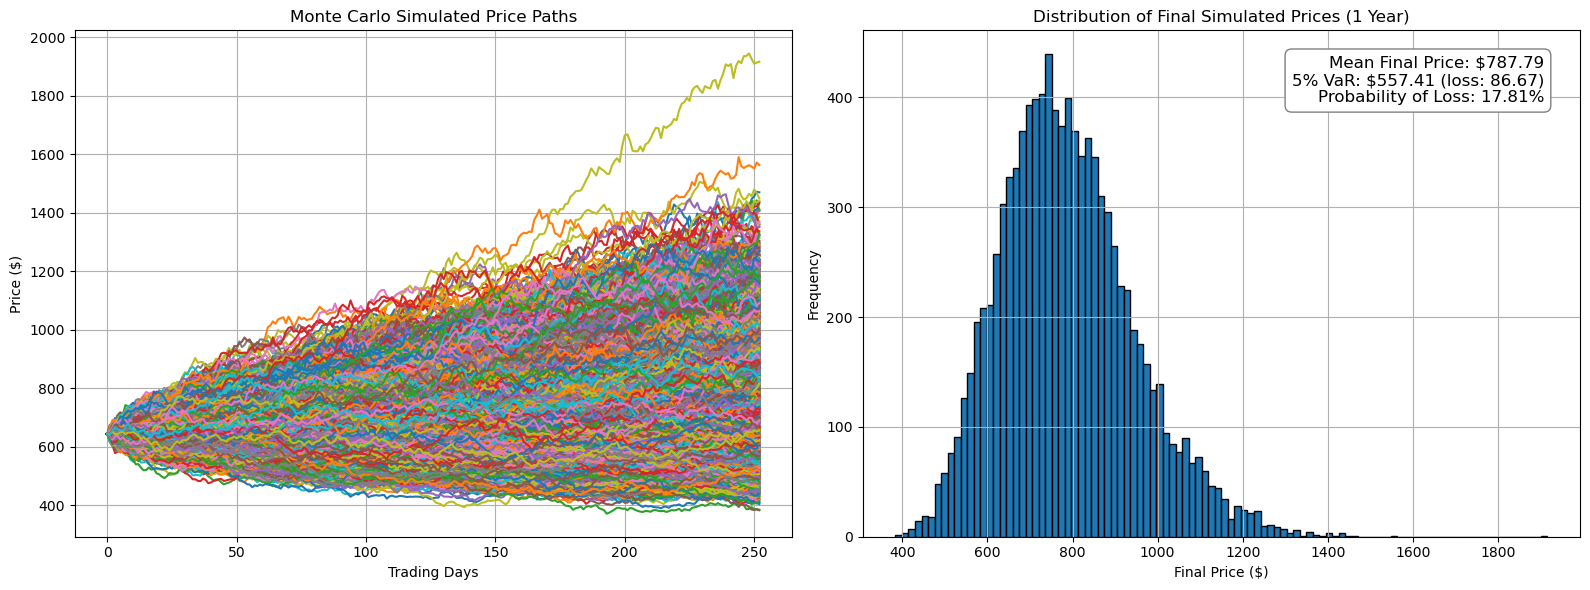

In [13]:
# Monte Carlo Simulated Price Paths for Single Stock

'''
Monte Carlo simulation models uncertainty by running the same process (eg: GBM) many times using random inputs. 

In can be used to:
- visualise a range of possible outcomes
- estimated the probability of gains or losses
- measure risk under extreme market conditions
'''

# Basic parameters (same as above, with the addition of M)
S0 = latest_close 
T = 1 
N = 252 
dt = T/N 
µ = logret.tail(lookback).mean() * N 
σ = logret.tail(lookback).std(ddof = 1) * np.sqrt(N)
M = 10000 # number of simulation paths

# Set up matrix for all paths
price_paths = np.zeros((M, N + 1))
price_paths[:, 0] = S0 # initialise first column to be S0

# Generate all values of Z
Z = np.random.normal(0, 1, size = (M, N))

# Simulate paths
for t in range(1, N + 1):
     price_paths[:, t] = price_paths[:, t-1] * np.exp((µ - 0.5 * σ ** 2) * dt + Z[:, t-1] * σ * np.sqrt(dt))
final_prices = price_paths[:, -1]

# Visualisation (2 subplots)
fig, axs = plt.subplots(1, 2, figsize = (16,6))

# Left subplot: Monte Carlo Simulated Price Paths
for i in range(M):
     axs[0].plot(price_paths[i])
axs[0].set_title("Monte Carlo Simulated Price Paths")
axs[0].set_xlabel("Trading Days")
axs[0].set_ylabel("Price ($)")
axs[0].grid(True)

# Right subplot: Distribution of Final Simulated Prices
axs[1].hist(final_prices, bins = 100, edgecolor = 'black')
axs[1].set_title("Distribution of Final Simulated Prices (1 Year)")
axs[1].set_xlabel("Final Price ($)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

mean_price = np.mean(final_prices)
var_5 = np.percentile(final_prices, 5)
prob_loss = np.mean(final_prices < S0)

risk_text = (
     f"Mean Final Price: ${mean_price:.2f}\n"
     f"5% VaR: ${var_5:.2f} (loss: {S0 - var_5:.2f})\n"
     f"Probability of Loss: {prob_loss:.2%}"
)

plt.gca().text(
     0.95, 0.95, risk_text,
     transform = plt.gca().transAxes,
     fontsize = 12,
     verticalalignment = 'top',
     horizontalalignment = 'right',
     bbox = dict(boxstyle = "round, pad = 0.4", facecolor = 'white', edgecolor = 'gray')
)
plt.tight_layout()
plt.show()

[*********************100%***********************]  3 of 3 completed


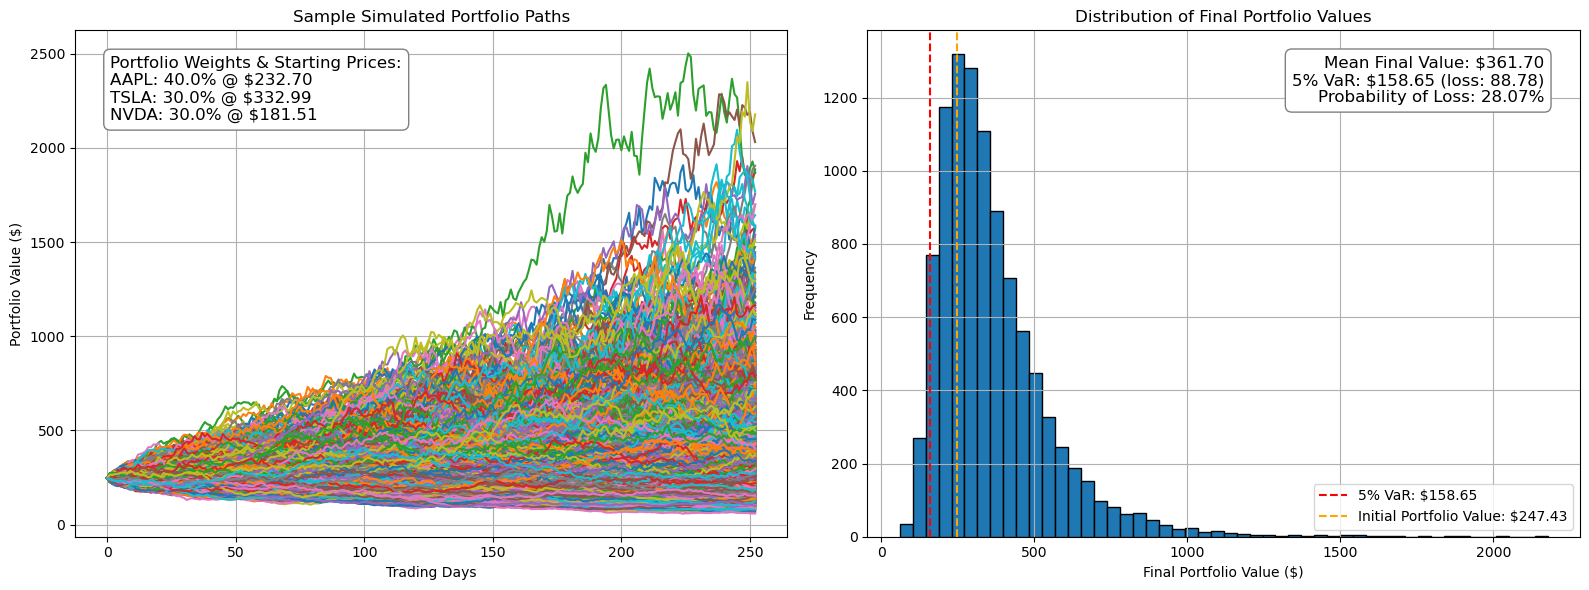

In [14]:
# Monte Carlo Portfolio Simulation using Matrix Multiplication

'''
We will simulate a multi-asset portfolio using:
- GBM
- Monte Carlo simulation
- matrix multiplication (to model correlated returns)
- risk metrics (eg: VaR & probability of loss)
'''

tickers = ["AAPL", "TSLA", "NVDA"]
n_assets = len(tickers)

def stock_pricing(symbol):
    ticker = yf.Ticker(symbol)
    latest = ticker.history(period = "1d")
    return latest['Close'].iloc[-1]

# Basic parameters
S0 = np.array([stock_pricing(stock) for stock in tickers])
T = 1
N = 252
dt = T/N
µ, σ = [], []
for ticker in tickers:
    hist = yf.Ticker(ticker).history(period = '3y', auto_adjust = True)
    logret = np.log(hist['Close'] / hist['Close'].shift(1)).dropna()
    µ.append(logret.tail(lookback).mean() * N)
    σ.append(logret.tail(lookback).std(ddof = 1) * np.sqrt(N))
µ = np.array(µ)
σ = np.array(σ)


weights = np.array([0.4, 0.3, 0.3]) # portfolio weights (sum to 1)
px = yf.download(tickers, period = '3y', auto_adjust = True)["Close"]
logret = np.log(px / px.shift(1)).dropna()
corr_matrix = logret.tail(lookback).corr().to_numpy()
cov_matrix = np.outer(σ, σ) * corr_matrix
L = np.linalg.cholesky(cov_matrix) # cholesky decomposition to get a lower-triangular matrix L
M = 10000 # number of simulations

# Initialise price paths for portfolio
portfolio_price_paths = np.zeros((M, N + 1, n_assets))
portfolio_price_paths[:, 0, :] = S0

# Simulate GBM with correlated shocks
for i in range(M):
    Z = np.random.normal(size = (N, n_assets))
    corr_Z = Z @ L.T
    for t in range(1, N + 1):
        portfolio_price_paths[i, t, :] = portfolio_price_paths[i, t-1, :] * np.exp((µ - 0.5 * σ ** 2) * dt + corr_Z[t-1] * np.sqrt(dt))

portfolio_values = np.sum(portfolio_price_paths * weights, axis = 2) # compute weighted portfolio value per simulation and timestep

# Visualisation (2 subplots)
fig, axs = plt.subplots(1, 2, figsize = (16,6))

# Left subplot: Simulation Paths
for i in range(M):
    axs[0].plot(portfolio_values[i])
axs[0].set_title("Sample Simulated Portfolio Paths")
axs[0].set_xlabel("Trading Days")
axs[0].set_ylabel("Portfolio Value ($)")
axs[0].grid(True)

weight_percent = weights * 100
weight_text = "Portfolio Weights & Starting Prices:\n"
for i in range(n_assets):
    weight_text += f"{tickers[i]}: {weight_percent[i]:.1f}% @ ${S0[i]:.2f}"
    weight_text += "" if i == n_assets - 1 else "\n" 

axs[0].text(
     0.05, 0.95, weight_text,
     transform = axs[0].transAxes,
     fontsize = 12,
     verticalalignment = 'top',
     horizontalalignment = 'left',
     bbox = dict(boxstyle = "round, pad = 0.4", facecolor = 'white', edgecolor = 'gray')
)

# Right subplot: Histogram of Final Portfolio Values
final_values = portfolio_values[:, -1]
initial = portfolio_values[0][0]
axs[1].hist(final_values, bins = 50, edgecolor = 'black')
axs[1].set_title("Distribution of Final Portfolio Values")
axs[1].set_xlabel("Final Portfolio Value ($)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

mean_value = np.mean(final_values)
var_5 = np.percentile(final_values, 5)
prob_loss = np.mean(final_values < initial)

risk_text = (
     f"Mean Final Value: ${mean_value:.2f}\n"
     f"5% VaR: ${var_5:.2f} (loss: {initial - var_5:.2f})\n"
     f"Probability of Loss: {prob_loss:.2%}"
)

plt.gca().text(
     0.95, 0.95, risk_text,
     transform = plt.gca().transAxes,
     fontsize = 12,
     verticalalignment = 'top',
     horizontalalignment = 'right',
     bbox = dict(boxstyle = "round, pad = 0.4", facecolor = 'white', edgecolor = 'gray')
)

axs[1].axvline(var_5, color = 'r', linestyle = '--', label = f"5% VaR: ${var_5:.2f}")
axs[1].axvline(initial, color = 'orange', linestyle = '--', label = f"Initial Portfolio Value: ${initial:.2f}")
axs[1].legend()

plt.tight_layout()
plt.show()